# Проверка гипотез, анализ результатов A/B теста.

Данные взяты с открытого источника Kaggle.com https://www.kaggle.com/datasets/sergylog/ab-test-data.

## Постановка задачи:

Сайт запустил A/B-тест с целью увеличения дохода. \
Данные содержат идентификатор пользователя(USER_ID), метку группы(VARIANT_NAME) и доход(REVENUE). \
Необходимо проанализировать результаты A/B-теста.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

Прочитаем файл и посмотрим общую информацию о данных.

In [2]:
df = pd.read_csv('AB_Test_Results.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [3]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Переименуем столбцы и название тестовой группы.

In [4]:
df = df.rename(columns={'USER_ID':'user_id','VARIANT_NAME':'group','REVENUE':'revenue'})
df = df.replace({'group': {'variant':'test'}})
df.head()

,user_id,group,revenue
0,737,test,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,test,0.0


Посмотрим на распределение revenue.

<AxesSubplot:xlabel='group', ylabel='revenue'>

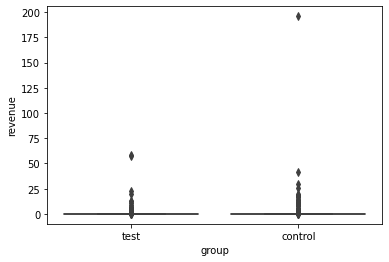

In [5]:
sns.boxplot(data=df, x="group", y="revenue")

Заметим, что большинство пользователей не совершали покупки. \
Поэтому сразу выделим пользователей, кто совершил хотя бы одну покупку.

In [6]:
df_paid = df[df.revenue > 0]

Посмотрим если пользователи, которые присутствуют в обеих группах.

In [7]:
df_paid.groupby("user_id")["group"].nunique().value_counts()

1    149
2      1
Name: group, dtype: int64

Такой пользователь один. Исключим его.

In [8]:
df_paid.groupby("user_id").filter(lambda x: x.group.nunique() > 1)

,user_id,group,revenue
4123,1252,test,1.25
8108,1252,control,1.26


In [9]:
df_paid = df_paid[df_paid.user_id != 1252]

Взглянем на точечный график.

<AxesSubplot:xlabel='user_id', ylabel='revenue'>

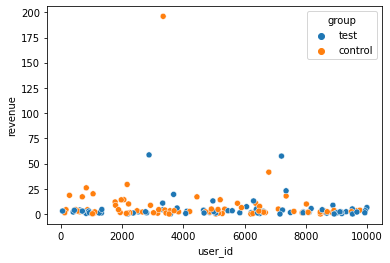

In [10]:
sns.scatterplot(data=df_paid, x="user_id", y="revenue", hue="group")

Заметим, что у нас есть несколько выбросов. Отсеем их по 99 персентилю.

In [11]:
revenue_percentile_99 = np.percentile(df_paid.revenue,99)
df_paid = df_paid[df_paid.revenue < revenue_percentile_99]

<AxesSubplot:xlabel='user_id', ylabel='revenue'>

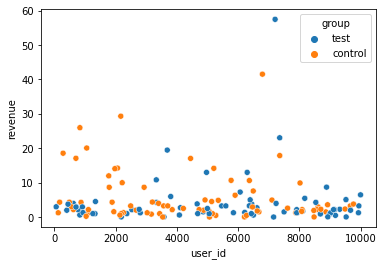

In [12]:
sns.scatterplot(data=df_paid, x="user_id", y="revenue", hue="group")

Посмотрим на описательные статистики данных, сгруппированных по группам.

In [13]:
df_paid.groupby('group').agg({'user_id':'nunique','revenue':['sum','mean','median','var']})

user_id revenue                            
        nunique     sum      mean median        var
group                                              
control      78  445.73  5.714487   2.96  54.371022
test         69  291.59  4.165571   2.17  58.556515

Разобъем нашу выборку на групповые подвыборки.

In [14]:
sample_A = df_paid[df_paid.group == "control"]
sample_B = df_paid[df_paid.group == "test"]

Заметим, что средний чек тестовой группы меньше среднего чека контрольной группы. \
Посмотрим величину относительного эффекта.

In [15]:
diffmean = sample_B.revenue.mean()-sample_A.revenue.mean()
diffmean

-1.54891575091575

In [16]:
print("Относительное изменение метрики: {0:.2f}%".format(diffmean / sample_A.revenue.mean() * 100))

Относительное изменение метрики: -27.11%


## T-тест
Проверим следующую гипотезу:

$H_0$: разница между средними групп статистически незначима

$H_1$: разница между средними групп статистически значима

Уровень значимости $\alpha=0.05$.

In [17]:
ttest = stats.ttest_ind(sample_A.revenue, sample_B.revenue)
ttest

Ttest_indResult(statistic=1.2532848125553924, pvalue=0.2121054257496136)

pvalue = 0.21 > 0.05  
Не отвергаем нулевую гипотезу: эффект статистически незначим.  
Дополнительно убедимся в этом, построив доверительный интервал для среднего.

Построим доверительный интервал для среднего. В силу ЦПТ, при достаточно большом объеме выборки среднее имеет нормальное распределение. Уровень значимости будем предполагать равному 5%.

In [18]:
ci_diffmean = stats.norm.interval(0.95, 
                    loc=diffmean,
                    scale=np.sqrt(np.var(sample_A.revenue)/len(sample_A)+np.var(sample_B.revenue)/len(sample_B)))
ci_diffmean

(-3.9595113028938607, 0.8616798010623605)

Полученный доверительный интервал содержит 0, следовательно, все так же получаем, что разница между средними групп статистически незначима.

Доверительный интервал относительного эффекта.

In [20]:
rel_ci_diffmean = (ci_diffmean[0] / sample_A.revenue.mean(), ci_diffmean[1] / sample_A.revenue.mean())
rel_ci_diffmean

(-0.6928900491905886, 0.15078864891944474)

## Вывод.

По результатам проведенного A/B теста, несмотря на то, что средний чек значительно упал, эффект тестируемой фичи оказался статистически незначим.  
Средняя выручка с пользователя составила: $-1.54\pm2.41$.  
Относительная средняя выручка с пользователя составила: $-27\%\pm42\%$

Вывод: между контрольной и тестовой группами нет статистически значимой разницы.